In [7]:
from dataclasses import dataclass, field
import yfinance as yf
from tqdm import tqdm
import pandas as pd
from typing import Dict, List, Any, Union
import logging
import os
import torch
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
# from langchain_ollama import OllamaLLM as Ollama
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain.prompts import PromptTemplate
import random
import re
from dotenv import load_dotenv
import time
import pickle

load_dotenv()

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)


# ---------------------------
# 1. Configuration Classes
# ---------------------------
@dataclass
class Config:
    tickers: List[str] = field(
        default_factory=lambda: ["AAPL", "GOOGL", "MSFT", "AMZN", "META"]
    )
    embedding_model: str = "all-MiniLM-L6-v2"
    top_k: int = 1


# ---------------------------
# 2. Data Loading: Quarterly Balance Sheets
# ---------------------------
class FinancialDataLoader:
    def __init__(self, config: Config):
        self.config = config
        self.logger = logging.getLogger(__name__)

    def load_quarterly_balance_sheets(self) -> Dict[str, pd.DataFrame]:
        balance_sheets = {}
        for ticker in tqdm(
            self.config.tickers, desc="Loading quarterly balance sheets"
        ):
            try:
                stock = yf.Ticker(ticker)
                # Using the quarterly balance sheet property from yfinance
                bs = stock.quarterly_balance_sheet
                bs.dropna(axis=1, thresh=0.5, inplace=True)
                bs.dropna(axis=0, thresh=0.5, inplace=True)
                if bs is not None and not bs.empty:
                    # (Transpose so that each row is one quarter if desired)
                    balance_sheets[ticker] = bs.T
                    self.logger.info(
                        f"Successfully loaded quarterly balance sheet for {ticker}"
                    )
            except Exception as e:
                self.logger.error(
                    f"Error loading quarterly balance sheet for {ticker}: {e}"
                )
        return balance_sheets


# ---------------------------
# 3. Financial Chunker & Balance Sheet Visualization
# ---------------------------
class FinancialChunker:
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(model_name)

    def create_chunks(self, balance_sheets: Dict[str, pd.DataFrame]) -> List[str]:
        """
        For each ticker and for each quarter in its balance sheet, create a text chunk.
        """
        chunks = []
        for ticker, df in balance_sheets.items():
            # Each row corresponds to one quarter (with the date as index)
            for date, row in df.iterrows():
                # Select a few key metrics if available (or iterate over all)
                total_assets = row.get("Total Assets", None)
                total_liabilities = row.get("Total Liab", None) or row.get(
                    "Total Liabilities", None
                )
                total_equity = row.get("Total Stockholder Equity", None) or row.get(
                    "Total Equity", None
                )

                # Build a summary text for the quarter.
                text = f"{ticker} Balance Sheet as of {date.strftime('%Y-%m-%d')}:\n"
                if total_assets is not None:
                    text += f"- Total Assets: {total_assets:,.0f}\n"
                if total_liabilities is not None:
                    text += f"- Total Liabilities: {total_liabilities:,.0f}\n"
                if total_equity is not None:
                    text += f"- Total Equity: {total_equity:,.0f}\n"
                # Optionally include additional metrics
                for metric, value in row.items():
                    if metric not in [
                        "Total Assets",
                        "Total Liab",
                        "Total Liabilities",
                        "Total Stockholder Equity",
                        "Total Equity",
                    ]:
                        text += f"- {metric}: {value}\n"
                chunks.append(text)
        return chunks

    def create_balance_sheet_visualization(
        self, balance_sheet: pd.DataFrame, ticker: str
    ) -> go.Figure:
        """
        Visualize a quarterly balance sheet as a Plotly table.
        """
        # Here, assume balance_sheet is a DataFrame where rows are quarters and columns are metrics.
        fig = go.Figure(
            data=[
                go.Table(
                    header=dict(
                        values=["Quarter"] + list(balance_sheet.columns),
                        fill_color="paleturquoise",
                        align="left",
                    ),
                    cells=dict(
                        values=[balance_sheet.index.strftime("%Y-%m-%d").tolist()]
                        + [
                            balance_sheet[col].tolist() for col in balance_sheet.columns
                        ],
                        fill_color="lavender",
                        align="left",
                    ),
                )
            ]
        )
        fig.update_layout(title_text=f"{ticker} Quarterly Balance Sheet")
        return fig


# ---------------------------
# 4. Vector Store & RAG System
# ---------------------------
class VectorStore:
    def __init__(self, config: Config):
        self.config = config
        self.model = SentenceTransformer(config.embedding_model)
        self.index = None
        self.chunks = []

    def create_index(self, chunks: List[str]):
        embeddings = self.model.encode(chunks)
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(np.array(embeddings).astype("float32"))
        self.chunks = chunks

    def search(self, query: str) -> List[str]:
        query_embedding = self.model.encode([query])
        D, I = self.index.search(
            np.array(query_embedding).astype("float32"), self.config.top_k
        )
        return [self.chunks[i] for i in I[0]]


class FinancialRAG:
    def __init__(self, config: Config):
        self.config = config
        self.loader = FinancialDataLoader(self.config)
        self.chunker = FinancialChunker(model_name=self.config.embedding_model)
        self.vector_store = VectorStore(self.config)
        self.logger = logging.getLogger(__name__)

    def initialize(self):
        # Load quarterly balance sheet data and create text chunks
        balance_sheets = self.loader.load_quarterly_balance_sheets()
        chunks = self.chunker.create_chunks(balance_sheets)
        self.vector_store.create_index(chunks)
        self.logger.info("RAG system initialized successfully")

    def query(self, question: str) -> List[str]:
        return self.vector_store.search(question)


# ---------------------------
# 5. Fine-Tuning the Embedding Model using Quarterly Balance Sheets
# ---------------------------
@dataclass
class TrainConfig:
    tickers: List[str] = field(
        default_factory=lambda: ["AAPL", "GOOGL", "MSFT", "AMZN", "META"]
    )
    epochs: int = 1000
    batch_size: int = 16
    learning_rate: float = 2e-5
    epsilon: float = 1e-6
    scheduler: str = "WarmupLinear"
    optimizer_class: Any = torch.optim.AdamW
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    model_output_dir: str = "fine-tuned-embedding-model"


def generate_questions(context: str) -> str:
    """
    Uses LangChain's Ollama LLM to generate a set of insightful questions
    for a given quarterly balance sheet summary.
    """
    rate_limiter = InMemoryRateLimiter(requests_per_second=0.1)
    
    # Uncomment and use Google's Gemini if desired.
    llm = GoogleGenerativeAI(
        model="gemini-1.5-flash",
        api_key=os.getenv("GOOGLE_API_KEY"),
        rate_limiter=rate_limiter
    )
    # prompt = f"Generate {num_questions} insightful questions about the following quarterly balance sheet summary:\n\n{summary}\n\nQuestions:"
    prompt = PromptTemplate(
        template="Generate one insightful question targeted for retrieval purposes about the following quarterly balance sheet summary:\n\n{context}\n\nQuestions:",
        input_variables=["context"],
    )
    chain = prompt | llm
    response = chain.invoke({"context": context})
    # Assume the response is a newline-separated list of questions.
    # Use regex to extract only the final question if any extra text exists.
    match = re.search(
        r"(?:Final Question:)(.*)", response, flags=re.IGNORECASE | re.DOTALL
    )
    if match:
        question = match.group(1).strip()
    else:
        question = response.strip()

    # As a safeguard, remove any stray chain-of-thought markers.
    question = re.sub(r"<think>.*?</think>", "", question, flags=re.DOTALL).strip()
    return question


class FinancialDataset:
    """
    Creates training examples using the balance sheet chunks generated by the chunker.
    For each chunk, a set of questions is generated using LangChain Ollama.
    A fraction of the generated examples is held out as a test dataset.
    """

    def __init__(
        self,
        balance_sheets: Dict[str, pd.DataFrame],
        chunker: FinancialChunker
    ):
        self.examples = []  # Training examples

        
        # check if pickle file exists
        if os.path.exists("qa_pairs.pkl"):
            print("Loading examples from pickle file")
            self.load_examples()
        else:
            self._create_examples(balance_sheets, chunker)

    def _create_examples(
        self,
        balance_sheets: List[dict],
        chunker: FinancialChunker
    ) -> None:
        """
        Create training and test examples from balance sheets.

        Args:
            balance_sheets: List of balance sheet dictionaries
            chunker: Chunker instance to split text
        """
        logging.info(f"Creating examples from {len(balance_sheets)} balance sheets")

        # Create chunks
        chunks = chunker.create_chunks(balance_sheets)
        all_examples: List[InputExample] = []

        # Generate questions for each chunk with progress bar
        for chunk in tqdm(chunks, desc="Generating questions", unit="chunk", leave=True, position=0):
            try:
                question = generate_questions(chunk)
                time.sleep(3)  # Rate limit to avoid API restrictions
                all_examples.append(InputExample(texts=[chunk, question]))
            except Exception as e:
                logging.error(f"Failed to generate question for chunk: {e}")
                continue

        self.examples = all_examples

        logging.info(
            f"Created {len(self.examples)} examples"
        )

    # save examples as pickle
    def save_examples(self):
        with open("qa_pairs.pkl", "wb") as f:
            pickle.dump(self.examples, f)

    # load examples from pickle
    def load_examples(self):
        with open("qa_pairs.pkl", "rb") as f:
            self.examples = pickle.load(f)


class ModelTrainer:
    def __init__(self, config: TrainConfig):
        self.config = config
        self.model = None
        self.model_output_dir = self.config.model_output_dir
        self.logger = logging.getLogger(__name__)

    def model_exists(self):
        return os.path.exists(self.model_output_dir)

    def load_model(self):
        if self.model_exists():
            self.model = SentenceTransformer(self.model_output_dir)
            self.logger.info(f"Loaded fine-tuned model from {self.model_output_dir}")
            return self.model
        return None

    def save_model(self):
        if self.model:
            self.model.save(self.model_output_dir)
            self.logger.info(f"Saved fine-tuned model to {self.model_output_dir}")

    def train(self, balance_sheets):
        if self.load_model():
            self.model = self.model
        else:
            self.model = SentenceTransformer(self.config.model_name)

        dataset = FinancialDataset(balance_sheets, FinancialChunker())
        dataloader = DataLoader(
            dataset.examples, batch_size=self.config.batch_size, shuffle=False
        )
        loss = losses.MultipleNegativesRankingLoss(self.model)

        self.model.fit(
            train_objectives=[(dataloader, loss)],
            epochs=self.config.epochs,
            scheduler=self.config.scheduler,
            optimizer_class=self.config.optimizer_class,
            optimizer_params={
                "lr": self.config.learning_rate,
                "eps": self.config.epsilon,
            },
            show_progress_bar=True,
        )

        self.save_model()
        return self.model


@dataclass
class EvaluationResult:
    query: str
    pre_contexts: List[str]
    post_contexts: List[str]
    pre_similarity: float
    post_similarity: float
    improvement: float


class EmbeddingEvaluator:
    def __init__(
        self, rag_pre: FinancialRAG, rag_post: FinancialRAG, queries: List[Any]
    ):
        self.rag_pre = rag_pre
        self.rag_post = rag_post
        self.test_queries = queries
        self.results = []

    def evaluate(self):
        from sklearn.metrics.pairwise import cosine_similarity

        for query in self.test_queries:
            query = query.texts[1]
            pre_contexts = self.rag_pre.query(query)
            post_contexts = self.rag_post.query(query)
            if any([not pre_contexts, not post_contexts]):
                continue
            pre_context = pre_contexts[0]
            post_context = post_contexts[0]
            # Encode the query and its retrieved top context
            pre_query_emb = self.rag_pre.vector_store.model.encode([query], show_progress_bar=False)
            pre_context_emb = self.rag_pre.vector_store.model.encode([pre_context], show_progress_bar=False)
            post_query_emb = self.rag_post.vector_store.model.encode([query], show_progress_bar=False)
            post_context_emb = self.rag_post.vector_store.model.encode([post_context], show_progress_bar=False)
            pre_sim = cosine_similarity(pre_query_emb, pre_context_emb)[0][0]
            post_sim = cosine_similarity(post_query_emb, post_context_emb)[0][0]
            self.results.append(
                EvaluationResult(
                    query=query,
                    pre_contexts=[pre_context],
                    post_contexts=[post_context],
                    pre_similarity=pre_sim,
                    post_similarity=post_sim,
                    improvement=post_sim - pre_sim,
                )
            )

    def visualize_results(self):
        improvements = [r.improvement for r in self.results]
        queries = [r.query for r in self.results]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=improvements, y=queries)
        plt.title("Embedding Performance Improvement")
        plt.xlabel("Improvement Score")
        plt.tight_layout()
        plt.savefig("embedding_comparison.png")
        return self.results


# ---------------------------
# 7. Running the Updated Exercise
# ---------------------------
# Initialize RAG system with pre-trained model using quarterly balance sheets
rag_pre = FinancialRAG(config=Config())
rag_pre.initialize()

# Load quarterly balance sheets for training and visualization
loader = FinancialDataLoader(Config())
quarterly_balance_sheets = loader.load_quarterly_balance_sheets()

2025-02-15 17:09:39,030 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 17:09:39,032 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-02-15 17:09:40,821 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 17:09:40,822 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Loading quarterly balance sheets:   0%|          | 0/5 [00:00<?, ?it/s]2025-02-15 17:09:41,546 - __main__ - INFO - Successfully loaded quarterly balance sheet for AAPL
2025-02-15 17:09:41,572 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
2025-02-15 17:09:41,601 - __main__ - INFO - Successfully loaded quarterly balance sheet for MSFT
2025-02-15 17:09:41,622 - __main__ - INFO - Successfully loaded quarterly balance sheet for AMZN
Batches: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]
2025-02-15 

In [5]:
# Fine tune the embedding model on quarterly balance sheet examples
train_config = TrainConfig()
trainer = ModelTrainer(train_config)
fine_tuned_model = trainer.train(quarterly_balance_sheets)

# Use the fine-tuned model in a new RAG system
rag_post = FinancialRAG(config=Config(embedding_model=train_config.model_output_dir))
rag_post.vector_store.model = fine_tuned_model  # Update the embedding model
rag_post.initialize()

2025-02-15 16:52:11,840 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 16:52:11,840 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
2025-02-15 16:52:12,160 - __main__ - INFO - Loaded fine-tuned model from fine-tuned-embedding-model
2025-02-15 16:52:12,164 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 16:52:12,164 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading examples from pickle file


Step,Training Loss
500,1.272500
1000,0.322900
1500,0.018400
2000,0.002600


2025-02-15 17:05:13,415 - sentence_transformers.SentenceTransformer - INFO - Save model to fine-tuned-embedding-model
2025-02-15 17:05:13,774 - __main__ - INFO - Saved fine-tuned model to fine-tuned-embedding-model
2025-02-15 17:05:13,783 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 17:05:13,784 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
2025-02-15 17:05:13,985 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-15 17:05:13,987 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
Loading quarterly balance sheets:   0%|          | 0/5 [00:00<?, ?it/s]2025-02-15 17:05:14,168 - __main__ - INFO - Successfully loaded quarterly balance sheet for AAPL
2025-02-15 17:05:14,199 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
2025-02-15 17:05:14,228 -

Batches: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s]
/var/folders/5j/l7cwj9sd0c1gqp3xyv7290sm0000gn/T/ipykernel_91065/2584070890.py:422: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Average Pre-Tuning Similarity: 0.508
Average Post-Tuning Similarity: 0.741
Average Improvement: 0.233


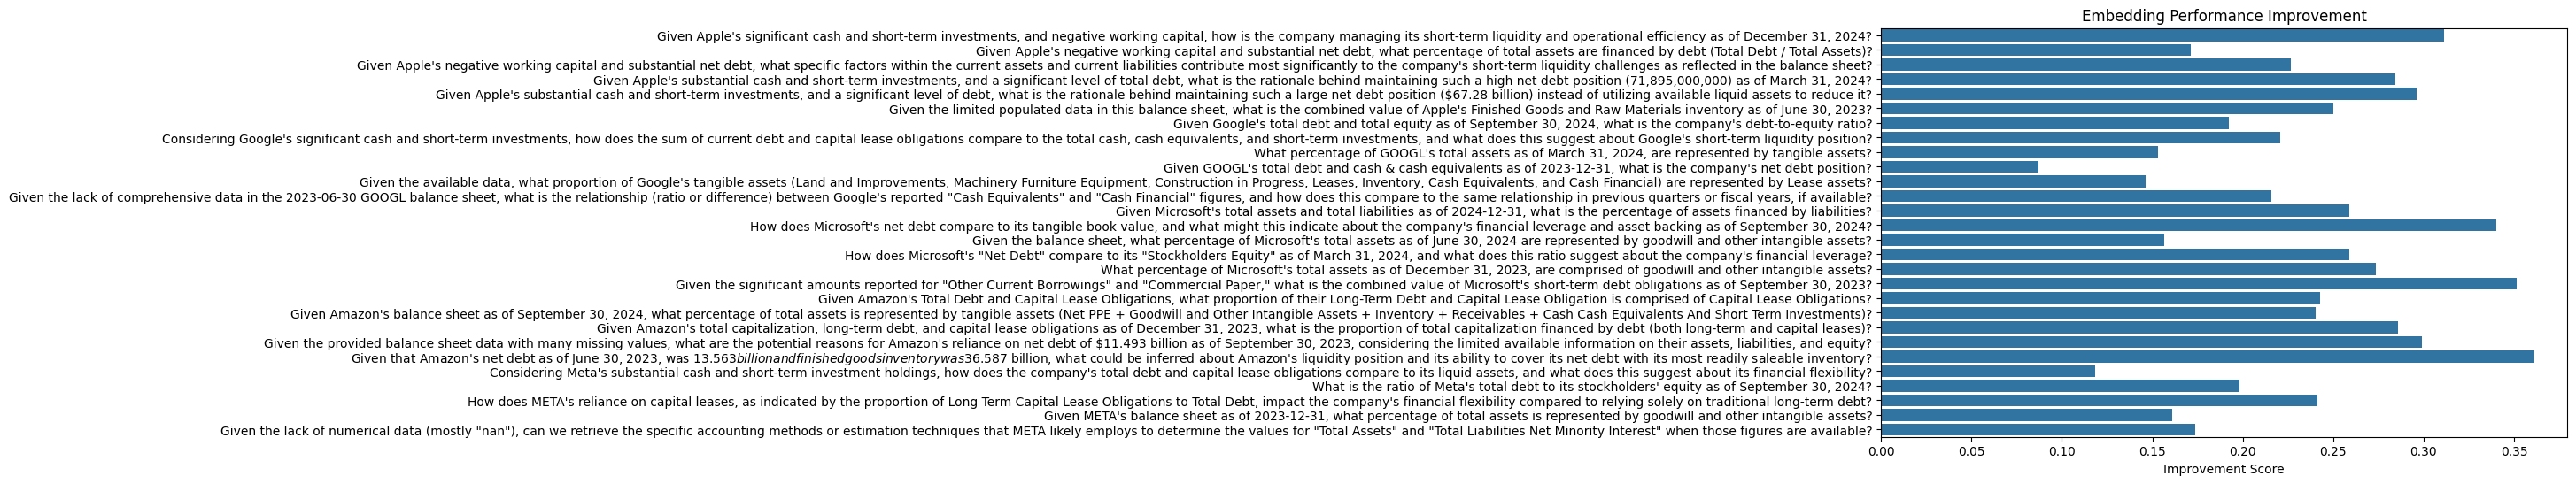

In [8]:
# Load QA pairs
with open("qa_pairs.pkl", "rb") as f:
    examples = pickle.load(f)

evaluator = EmbeddingEvaluator(
    rag_pre=rag_pre, rag_post=rag_post, queries=examples
)
evaluator.evaluate()
results = evaluator.visualize_results()

pre_tuning_similarities = [r.pre_similarity for r in results]
post_tuning_similarities = [r.post_similarity for r in results]
improvements = [r.improvement for r in results]

# Print statistics
print(f"Average Pre-Tuning Similarity: {np.mean(pre_tuning_similarities):.3f}")
print(f"Average Post-Tuning Similarity: {np.mean(post_tuning_similarities):.3f}")
print(f"Average Improvement: {np.mean(improvements):.3f}")